In [1]:
from invisible_cities.cities.components import wf_from_files, WfType
from invisible_cities.cities.components import deconv_pmt, calibrate_pmts, get_pmt_wfs, load_dst
from invisible_cities.io.pmaps_io import load_pmaps
from invisible_cities.io.pmaps_io import load_pmaps_as_df
import pandas as pd
import numpy as np
import tables as tb
import os
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from mpl_interactions import ioff, panhandler, zoom_factory
import glob
from matplotlib.colors import LogNorm

In [23]:
# Load in the pmaps from the data

pmaps_data = load_pmaps_as_df("../data/run_13852_0000_ldc1_trg0_irene.h5")

s1_pmaps_data = pmaps_data[0]
s2_pmaps_data = pmaps_data[1]

# want event 37
display(s1_pmaps_data)
print(s1_pmaps_data.event.unique())

,event,peak,time,bwidth,ene
0,9,0,1925.0,25.0,0.364390
1,9,0,1950.0,25.0,0.638245
2,9,0,1975.0,25.0,0.906407
3,9,0,2000.0,25.0,0.763632
4,9,0,2025.0,25.0,0.396182
...,...,...,...,...,...
25245,597,0,216500.0,25.0,0.430239
25246,597,0,216525.0,25.0,0.662060
25247,597,0,216550.0,25.0,0.525257
25248,597,0,216575.0,25.0,0.622339


[  9  37  58  65  72  79  86 100 121 149 156 170 177 205 212 219 247 261
 268 275 282 296 310 324 338 345 366 408 415 422 436 450 485 492 506 513
 534 541 555 562 569 576 583 590 597]


In [85]:
# load in sophrinia
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
soph = pd.read_hdf("../data/run_13852_0000_ldc1_trg0_sophronia.h5", "/DST/Events")
display(soph)

,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,S2w,S2h,S2e,S2q,S2t,qmax,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
0,9,1.717754e+09,0,0,1,1,12225.0,9.031772,1435.904907,4275.0,95.625,26365.119141,260967.968750,23256.699219,1.007486e+06,3306.755127,172,1003.211548,1484.753052,7.171289,-233.826213,12.134715,234.140874,3.089743,45.123563,54.155581
1,16,1.717754e+09,65535,0,0,2,NaN,NaN,NaN,NaN,217.075,24529.240234,275962.406250,28184.617188,1.008484e+06,2527.028809,311,NaN,NaN,9.955354,-68.749405,230.324953,240.366522,1.860866,82.275656,116.144946
2,16,1.717754e+09,65535,1,0,2,NaN,NaN,NaN,NaN,232.750,233.425171,1393.298096,541.970398,1.823399e+06,169.696960,12,NaN,NaN,53.646273,-217.989219,-85.653256,234.213107,-2.767201,187.134440,253.763614
3,37,1.717754e+09,0,0,1,1,7850.0,66.376595,1036.376953,212825.0,176.350,19400.361328,321305.156250,35432.992188,1.012486e+06,1560.313232,295,799.661438,1183.498779,10.757016,-132.690325,32.494958,136.611291,2.901426,67.226978,70.097465
4,44,1.717754e+09,65535,0,0,1,NaN,NaN,NaN,NaN,217.475,17374.078125,234880.390625,20355.441406,1.009480e+06,1418.307861,195,NaN,NaN,11.349628,-228.230542,-236.392953,328.589118,-2.338629,80.895054,83.323188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,548,1.717754e+09,65535,0,0,1,NaN,NaN,NaN,NaN,136.850,19582.462891,253123.312500,21717.919922,1.008485e+06,1729.734619,178,NaN,NaN,9.496315,-129.475330,-198.450475,236.952426,-2.148879,63.862255,68.401621
71,555,1.717754e+09,0,0,1,1,5175.0,44.339481,659.063354,272975.0,166.150,16346.099609,261742.359375,27320.335938,1.010488e+06,1406.697876,225,737.512939,1091.519043,9.910628,257.753528,-1.655720,257.758846,-0.006424,86.524700,73.539994
72,569,1.717754e+09,0,0,1,1,7350.0,42.901512,766.747009,207075.0,334.225,6100.304199,98692.046875,9893.287109,1.008486e+06,381.133331,167,801.411438,1186.088867,18.808639,28.363758,189.604198,191.713992,1.422303,143.332737,191.529158
73,576,1.717754e+09,0,0,1,1,12100.0,7.700148,1241.101440,845625.0,170.075,42165.351562,324834.406250,38128.457031,1.004478e+06,3567.688232,286,158.852890,235.102249,10.243380,-266.111989,335.327170,428.088661,2.241616,76.034628,99.320626


,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,S2w,S2h,S2e,S2q,S2t,qmax,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
7,72,1.717754e+09,0,0,1,1,5450.0,48.664997,700.406372,358975.0,184.150,16816.050781,252341.796875,28213.908203,1.012486e+06,1538.366333,249,653.510803,967.195923,10.091286,372.555656,113.803954,389.549813,0.296466,103.446250,92.708003
9,93,1.717754e+09,65535,0,0,1,NaN,NaN,NaN,NaN,149.125,21528.716797,261032.828125,23825.898438,1.007488e+06,1839.866699,222,NaN,NaN,9.299986,72.846601,291.872534,300.825869,1.326210,66.822390,98.443867
21,177,1.717754e+09,0,0,1,1,5825.0,50.781849,835.430786,372375.0,192.200,6283.628418,96367.820312,11996.541016,1.008484e+06,972.261719,93,636.109497,941.441956,12.112171,352.280094,92.746751,364.284537,0.257434,120.698539,149.133195
23,191,1.717754e+09,65535,0,0,2,NaN,NaN,NaN,NaN,141.225,23692.802734,253537.750000,25812.773438,1.007482e+06,2510.192139,230,NaN,NaN,9.682031,311.523019,77.890572,321.112959,0.245008,96.561016,72.418718
35,254,1.717754e+09,65535,0,0,1,NaN,NaN,NaN,NaN,187.125,15431.634766,245758.468750,23779.554688,1.010484e+06,1197.099609,209,NaN,NaN,10.656583,106.289374,319.026162,336.266446,1.249194,77.343022,111.380632
36,261,1.717754e+09,0,0,1,1,14150.0,7.096507,1613.126953,635675.0,204.875,19899.939453,257310.875000,24742.531250,1.009491e+06,1515.574951,281,373.815643,553.247131,11.005560,172.799779,263.519611,315.122753,0.990398,101.440713,119.485527
64,506,1.717754e+09,0,1,2,2,6075.0,46.340706,742.011475,208875.0,157.075,13764.711914,230398.953125,23087.875000,1.269490e+06,993.639526,203,1060.615356,1569.710571,9.530285,312.710947,171.744651,356.769339,0.502238,92.054365,89.032701
66,506,1.717754e+09,1,1,2,2,5200.0,47.948402,730.289673,468700.0,157.075,13764.711914,230398.953125,23087.875000,1.269490e+06,993.639526,203,800.790283,1185.169556,9.530285,312.710947,171.744651,356.769339,0.502238,92.054365,89.032701


,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,S2w,S2h,S2e,S2q,S2t,qmax,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
4,44,1.717754e+09,65535,0,0,1,NaN,NaN,NaN,NaN,217.475,17374.078125,234880.390625,20355.441406,1.009480e+06,1418.307861,195,NaN,NaN,11.349628,-228.230542,-236.392953,328.589118,-2.338629,80.895054,83.323188
5,51,1.717754e+09,65535,0,0,1,NaN,NaN,NaN,NaN,167.075,16865.820312,253049.484375,25063.591797,1.011486e+06,1393.291870,205,NaN,NaN,10.246372,-289.431144,-107.331037,308.691332,-2.786479,73.543397,67.979136
6,58,1.717754e+09,0,0,1,1,7425.0,61.405529,999.220459,207375.0,114.800,4577.068848,74380.031250,6689.515137,1.008486e+06,462.226654,63,801.110657,1185.643677,9.624564,-420.077359,57.770754,424.031187,3.004926,66.167841,65.379169
12,121,1.717754e+09,0,0,1,1,7700.0,43.132942,808.897461,206150.0,197.250,10143.477539,166296.046875,18933.515625,1.009491e+06,961.935974,158,803.340759,1188.944336,11.739775,-7.541972,-394.655716,394.727774,-1.589904,63.379621,84.200211
41,289,1.717754e+09,65535,0,0,2,NaN,NaN,NaN,NaN,148.800,3387.828125,44584.929688,513.501587,1.002490e+06,218.181824,12,NaN,NaN,10.141158,-188.000194,-227.567394,295.179592,-2.261268,166.664548,231.220019
48,359,1.717754e+09,65535,0,0,1,NaN,NaN,NaN,NaN,171.575,24004.167969,207999.625000,23274.757812,1.005490e+06,2676.697754,162,NaN,NaN,8.755391,0.594481,-437.508419,437.508822,-1.569438,57.566109,70.021641
52,415,1.717754e+09,0,0,1,1,5225.0,40.452888,597.609985,777050.0,130.000,13086.881836,149046.234375,16189.426758,1.007488e+06,1813.633179,99,230.437637,341.047668,8.415629,-1.768981,-438.178703,438.182274,-1.574833,51.540826,58.084939
63,506,1.717754e+09,0,0,2,2,6075.0,46.340706,742.011475,208875.0,128.575,10744.889648,173201.218750,12909.729492,1.010483e+06,742.633545,101,801.608154,1186.380005,9.782702,-193.864698,-232.224491,302.509066,-2.266409,45.265920,50.754342
65,506,1.717754e+09,1,0,2,2,5200.0,47.948402,730.289673,468700.0,128.575,10744.889648,173201.218750,12909.729492,1.010483e+06,742.633545,101,541.783142,801.838989,9.782702,-193.864698,-232.224491,302.509066,-2.266409,45.265920,50.754342


,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,S2w,S2h,S2e,S2q,S2t,qmax,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
1,16,1.717754e+09,65535,0,0,2,NaN,NaN,NaN,NaN,217.075,24529.240234,275962.40625,28184.617188,1.008484e+06,2527.028809,311,NaN,NaN,9.955354,-68.749405,230.324953,240.366522,1.860866,82.275656,116.144946
8,79,1.717754e+09,0,0,1,1,5500.0,48.292225,668.399414,371175.0,145.850,18530.156250,283722.43750,27383.070312,1.010490e+06,1425.889771,241,639.315491,946.186829,10.402396,143.475040,-148.890123,206.768846,-0.803918,68.227289,61.985605
11,107,1.717754e+09,65535,0,0,1,NaN,NaN,NaN,NaN,118.150,29576.445312,283350.87500,29830.968750,1.005492e+06,3161.790283,212,NaN,NaN,8.599942,-71.106011,176.164451,189.973626,1.954432,55.777490,70.536370
16,142,1.717754e+09,65535,0,0,1,NaN,NaN,NaN,NaN,172.675,17020.480469,297289.25000,26182.785156,1.013486e+06,1078.077393,247,NaN,NaN,10.906600,47.016563,87.327988,99.180313,1.076910,75.944235,73.255035
17,149,1.717754e+09,0,0,1,1,7425.0,57.264095,741.322144,239800.0,256.350,16430.109375,268944.12500,28215.652344,1.012490e+06,1277.964966,331,772.690125,1143.581299,15.242099,-121.521541,297.230461,321.112802,1.958905,89.457234,122.653423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,443,1.717754e+09,65535,0,0,1,NaN,NaN,NaN,NaN,164.325,22685.244141,309126.34375,34150.562500,1.010491e+06,2193.041992,257,NaN,NaN,10.316220,-63.639367,157.409981,169.787724,1.954996,62.525993,74.827206
59,457,1.717754e+09,65535,0,0,1,NaN,NaN,NaN,NaN,602.600,16960.437500,294026.78125,62557.601562,1.013491e+06,1375.817627,1325,NaN,NaN,30.200475,-62.978373,66.884538,91.868476,2.326124,185.863197,188.493960
60,471,1.717754e+09,65535,0,0,1,NaN,NaN,NaN,NaN,146.050,28867.298828,263118.46875,30317.990234,1.005490e+06,2831.185303,250,NaN,NaN,9.214145,-242.153490,279.657598,369.927945,2.284445,65.465330,79.260768
61,485,1.717754e+09,0,0,1,1,5125.0,42.686108,610.991699,383825.0,154.350,18133.082031,276590.03125,30424.976562,1.010487e+06,1568.724854,252,626.662415,927.460327,9.894903,246.539438,-126.584988,277.137968,-0.474347,89.638874,64.311425


Text(0, 0.5, 'y [mm]')

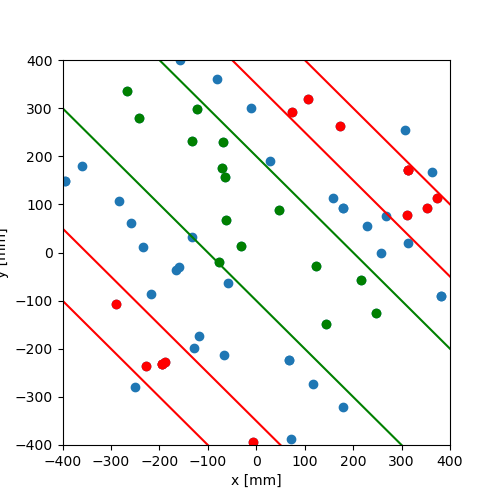

In [131]:
plt.figure(figsize=(5,5))
plt.scatter(soph.X,soph.Y)

## -- 
line1 = lambda x: -x + 350
line2 = lambda x: -x + 500

section_1 = soph[(soph['Y'] > line1(soph['X'])) & (soph['Y'] < line2(soph['X']))]
plt.scatter(section_1.X,section_1.Y, c="r")

## -- 
line3 = lambda x: -x - 350
line4 = lambda x: -x - 500

section_2 = soph[(soph['Y'] < line3(soph['X'])) & (soph['Y']> line4(soph['X']))]
plt.scatter(section_2.X,section_2.Y, c="r")

# --

line5 = lambda x: -x - 100
line6 = lambda x: -x + 200

section_3 = soph[(soph['Y'] > line5(soph['X'])) & (soph['Y'] < line6(soph['X']))]
plt.scatter(section_3.X,section_3.Y, c="green")



x_line = np.linspace(-400,400, 100)
y_line = -1*x_line-100
plt.plot(x_line, y_line, color='green')
y_line = -1*x_line+200
plt.plot(x_line, y_line, color='green')

y_line = -1*x_line-350
plt.plot(x_line, y_line, color='red')
y_line = -1*x_line-500
plt.plot(x_line, y_line, color='red')


y_line = -1*x_line+350
plt.plot(x_line, y_line, color='red')
y_line = -1*x_line+500
plt.plot(x_line, y_line, color='red')


plt.xlim(-400,400)
plt.ylim(-400,400)

display(section_1)
display(section_2)
display(section_3)

sec1_ids = section_1.event.unique()
sec2_ids = section_2.event.unique()
sec3_ids = section_3.event.unique()

plt.xlabel("x [mm]")
plt.ylabel("y [mm]")


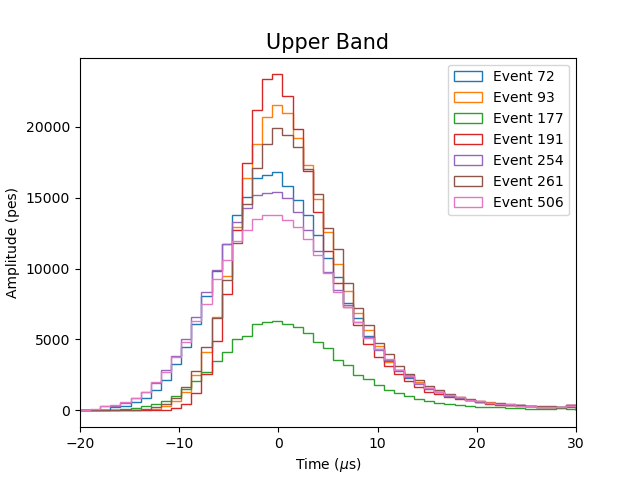

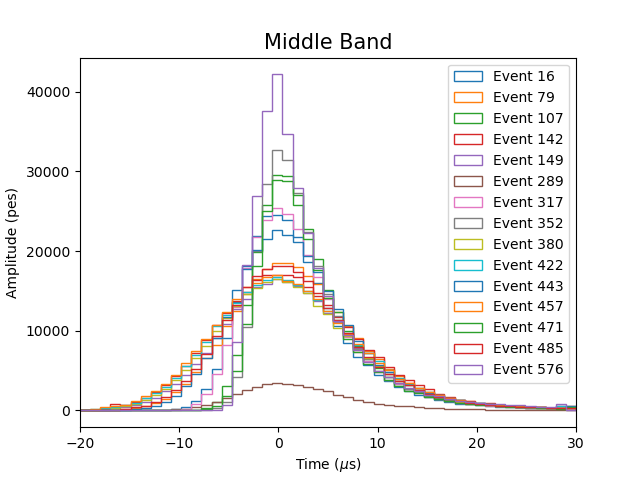

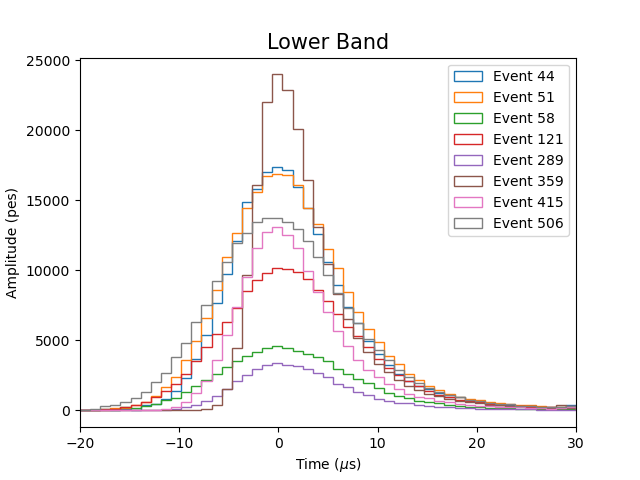

In [127]:
# Plot the S2 PMAPS
%matplotlib widget
s2s_data = pmaps_data[1]

sec1_s2pmaps = s2s_data[s2s_data.event.isin(sec1_ids)]
sec2_s2pmaps = s2s_data[s2s_data.event.isin(sec2_ids)]
sec3_s2pmaps = s2s_data[s2s_data.event.isin(sec3_ids)]

def plot_events(sec_s2pmaps,title):

    plt.figure()
    for eid in sec_s2pmaps.event.unique():
        # print("Event: ",eid)

        s2s_data   = sec_s2pmaps[sec_s2pmaps.event == eid]
        # s2sis = s2sis.loc[lambda df: df.event == eventid]

        max_ene_row = s2s_data.loc[s2s_data['ene'].idxmax()]

        # Get the value of 'peak' for the largest 'ene'
        peak_value = max_ene_row['peak']
        data = s2s_data[s2s_data.peak == peak_value]
        plt.hist(data.time / 1e3 - max_ene_row.time/1e3, weights=data.ene, label=f"Event {eid}",histtype="step", bins = np.linspace(-20,30,50)) # plot the PMT-summed waveform slice


        plt.xlabel("Time ($\mu$s)")
        plt.ylabel("Amplitude (pes)")
        plt.title(f"{title}", fontsize=15);
        plt.xlim(-20,30)
        plt.legend()

plot_events(sec1_s2pmaps, "Upper Band")
plot_events(sec3_s2pmaps, "Middle Band")
plot_events(sec2_s2pmaps, "Lower Band")


[]

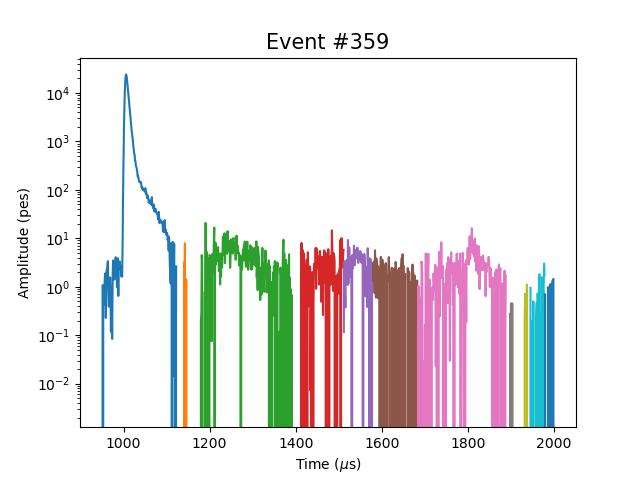

In [129]:
%matplotlib widget
s1s_data, s2s_data, s2sis, s1pmts, s2pmts = pmaps_data

plt.figure()

# for index, eventid in enumerate(s1s_data.event.unique()):
    # print(eventid)

    # if index > 5: break


eventid = 359

s1s_data   = s1s_data  .loc[lambda df: df.event == eventid]
s2s_data   = s2s_data  .loc[lambda df: df.event == eventid]
# s2sis = s2sis.loc[lambda df: df.event == eventid]

for _, s1 in s1s_data.groupby("peak"):
    plt.plot(s1.time / 1e3, s1.ene) # plot the PMT-summed waveform slice


for _, s2 in s2s_data.groupby("peak"):
    plt.plot(s2.time / 1e3, s2.ene) # plot the PMT-summed waveform slice


plt.xlabel("Time ($\mu$s)")
plt.ylabel("Amplitude (pes)")
plt.title(f"Event #{eventid}", fontsize=15);
plt.semilogy()

    # plt.savefig(f"../plots/pmaps/{eventid}.png")
    # plt.clf()